In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# MNIST Data Pre-processing
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils  # utilities for one-hot encoding of ground truth values

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train, 10).astype(np.float32)
y_test = np_utils.to_categorical(y_test, 10).astype(np.float32)

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
from Model import GAN

Gan, G, D, F = GAN([28,28,1], 'A', 2, 5)

epochs=100
batch_size=128

target=0

x_train_selected = x_train
y_train_selected = y_train

for cur_epoch in range(epochs):
    for discrm_epoch in range(8):
        input_batch = x_train_selected[np.random.randint(0, x_train_selected.shape[0], size=int(batch_size)),]
        y_discrim = np.ones([batch_size,1])
        if discrm_epoch % 2 == 0:
            input_batch = np.add(input_batch, G.predict(input_batch))
            y_discrim = np.zeros([batch_size,1])
        D.train_on_batch(input_batch, y_discrim)
        
    input_idx = np.random.randint(0, x_train_selected.shape[0], size=int(batch_size))
    input_batch = x_train_selected[input_idx,]
    y_discrim = np.ones([batch_size,1])
    #y_class = y_train_selected[input_idx,]
    y_class=np_utils.to_categorical(np.ones(batch_size)*target, 10).astype(np.float32)
    y_hinge=np.zeros([batch_size,28,28,1])
    scalarloss=Gan.train_on_batch(input_batch, [y_discrim, y_class, y_hinge])
    print("Epoch number:",cur_epoch,"; Loss",scalarloss)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch number: 0 ; Loss [4.432431, 0.70399237, 0.83270985, 0.41260386]
Epoch number: 1 ; Loss [3.9050698, 0.8563978, 0.7832609, 0.29643005]
Epoch number: 2 ; Loss [3.7320113, 0.9637579, 0.7903248, 0.2375208]
Epoch number: 3 ; Loss [3.487907, 0.9711309, 0.7585534, 0.19993384]
Epoch number: 4 ; Loss [3.260912, 0.95269305, 0.77734125, 0.1507073]
Epoch number: 5 ; Loss [3.0448847, 0.9456939, 0.754051, 0.11821778]
Epoch number: 6 ; Loss [3.0508823, 0.9608732, 0.8091073, 0.09435891]
Epoch number: 7 ; Loss [3.0247355, 0.959484, 0.8355286, 0.078838825]
Epoch number: 8 ; Loss [2.9460828, 0.94227934, 0.84406614, 0.06313422]
Epoch number: 9 ; Loss [2.8862038, 0.9361166, 0.84813285, 0.050764255]
Epoch number: 10 ; Loss [2.8159595, 0.9518533, 0.81179553, 0.048103053]
Epoch number: 11 ; Loss [2.929098, 0.94549006, 0.8860272, 0.04231069]
Epoch number: 12 ; Loss [2.8997998, 0.95053184, 0.87982833, 0.037922308]
Epoch number: 13 ; Loss [2.830335, 0.9492817, 0.8516586, 0.035547204]
Epoch number: 14 ; Loss

In [32]:
import matplotlib.pyplot as plt
import pickle

#idx = range(x_train.shape[0])
idx = np.random.randint(0, x_train_selected.shape[0], size=int(1000))
real = x_train[idx,]
fake = real + G.predict(real)
pdt = np.argmax(Gan.predict(real)[1], axis=1)
label = np.argmax(y_train[idx,], axis=1)
idx = (pdt != label)
real = real[idx,]
fake = fake[idx,]
pdt = pdt[idx,]
label = label[idx,]
idx = np.argsort(np.mean((real-fake)**2, axis=(1,2,3)))
real = real[idx,]
fake = fake[idx,]
pdt = pdt[idx,]
label = label[idx,]


record = {
    'label': label,
    'pdt': pdt,
    'real': real,
    'fake': fake,
}

with open('WB-C.pickle', 'wb') as handle:
    pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
unique, counts = np.unique(10*label+pdt, return_counts=True)
print(len(unique), dict(zip(unique, counts)))

6 {38: 1, 72: 1, 58: 1, 59: 1, 14: 1, 79: 1}


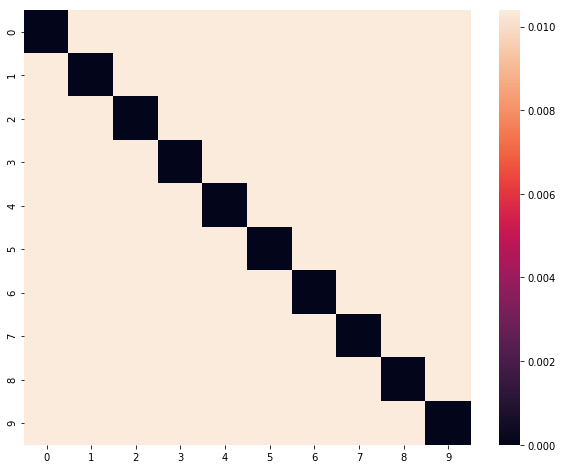

In [34]:
d = dict(zip(unique, counts))
n = np.zeros((10,10))
m = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        n[i,j] = d[10*i+j] if (10*i+j) in d else int(i!=j)
        idx = np.logical_and(label==i, pdt==j)
        m[i,j] = np.median(np.mean((real[idx,]-fake[idx,])**2, axis=(1,2,3))) if (10*i+j) in d else float(i!=j)*0.07

import seaborn
plt.figure(figsize=(10,8))
plt.xlabel('adasd')
n = np.log(n+1)*0.015
seaborn.heatmap(n)
#seaborn.heatmap(m)

6


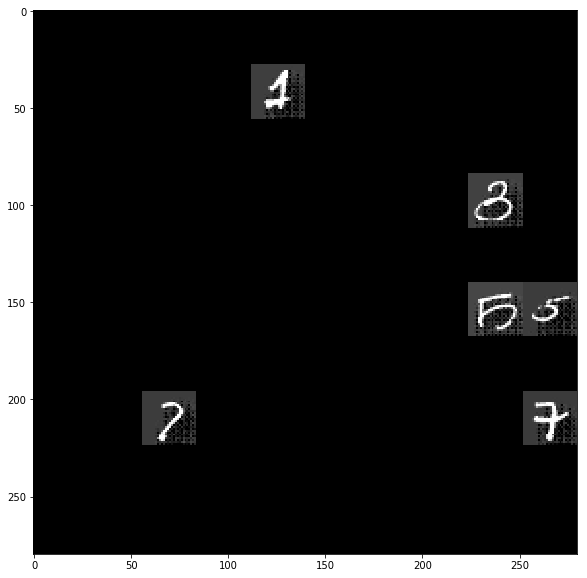

In [35]:
image = np.zeros((280,280,1))

c = {}

for i in range(10):
    for j in range(10):
        idx = np.logical_and(label==i, pdt==j)
        if (10*i+j) in d and (10*i+j) not in c:
            c[10*i+j] = fake[idx][0]
        image[28*i:28*(i+1),28*j:28*(j+1),:] = c[10*i+j] if (10*i+j) in c else np.zeros((28,28,1))
        
print(len(c.keys()))

plt.figure(figsize=(10,10))
plt.imshow(np.clip(image*255, 0, 255).astype(np.int).reshape(280,280), cmap='gray')
plt.show()

3


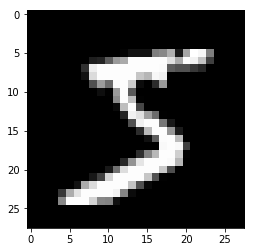

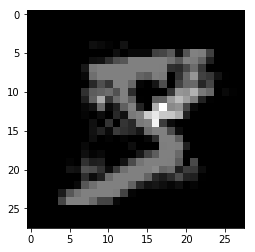

8


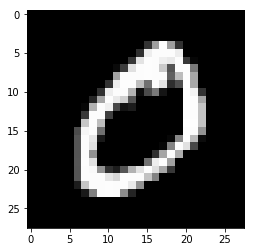

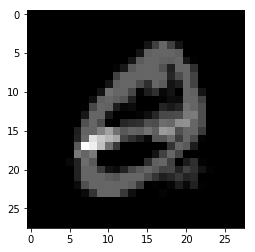

7


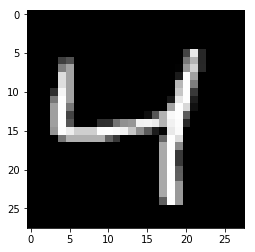

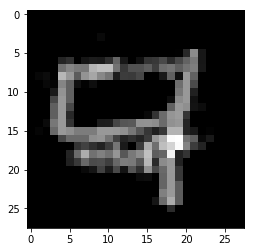

In [94]:
for k in range(3):
    print(pdt[k,])
    plt.imshow((real[k,] * 255).astype(np.int).reshape(28,28), cmap='gray')
    plt.show()
    plt.imshow((fake[k,] * 255).astype(np.int).reshape(28,28), cmap='gray')
    plt.show()

In [ ]:
with open('WB-C.pickle', 'rb') as handle:
    record = pickle.load(handle)